# Problem Statement
To predict if a kickstarter project will be successful or will fail before its actual deadline. Also identify the factors that determine the success rate of a project.


# Solution Notebook
This notebook basically has 4 steps/ modules:
    1. Data Understanding (EDA) and Preprocessing
    2. Feature Engineering and heuristic feature selection
    3. Model Building
        3A. Logistic Regression with grid search
        3B. XGBoost
        3C. Random Forest
    4. Feature importance
    
The best accuracy obtained was 68.9% accuracy on Test Data from XGBoost

## setting up the requires libraries and packages

In [173]:
# Libraries
import numpy as np
import pandas as pd
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import string
#import itertools
#from itertools import product

In [174]:
#setting working directory
#os.chdir("/home/srishti/Srishti Saha- backup/misc/personal/kickstarter_projects")

## Importing a dataset

In [175]:
# read in data
kickstarters_2017 = pd.read_csv("ks-projects-201801.csv")
kickstarters_2017.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Basic Tests and EDA on input data

In [176]:
#printing all summary of the kickstarter data
#this will give the dimensions of data set : (rows, columns)
print(kickstarters_2017.shape)
#columns and data types
print(kickstarters_2017.info())
#basic stats of columns
print(kickstarters_2017.describe())
#number of unique values in all columns
print(kickstarters_2017.nunique())

(378661, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None
                 ID          goal       pledged        backers   usd pledged  \
count  3.786610e+05  3.786610e+05  3.786610e+05  378661.000000  3.748640e+05   


The above stats help us reaching the following conclusions:
1. the data is at ID level (unique of ID=number of rows)
2. The numerical data fields are: goal, pledged, backers, usd_pledged, usd_pledged_real,usd_goal_real

#### Understanding Variables in the Dataset

The dataset has 15 variablesincluding ID. SInce ID is the level of the dataset, we can set it as the index of the ata later. Variables like name, currency, deadline, launched date and country as self explanatory. Explanations of some key variables are as follows:

Main_Category: There are 15 main categories for the project. These main categories broadly classify projects based on topic and genre they belong to.

Category: Main Categories are further sub divided in categories to give more general idea of the project. For example, Main Category “Technology” has 15 categories like Gadgets, Web, Apps, Software etc. There are 159 total categories.

Goal: This is the goal amount which the company need to raise to start its project. The goal amount is important variable for company as if it is too high, the project may fail to raise that amount of money and be unsuccessful. If it is too low, then it may reach its goal soon and backers may not be interested to pledge more.

Pledged: This is amount raised by the company through its backers. On Kickstarter, if total amount pledged is lower than goal, then the project is unsuccessful and the start-up company doesn’t receive any fund. If pledged amount is more than the goal, the company is considered successful. The variable “usd pledged” is amount of money raised in US dollars.

Number of Backers: These are number of people who have supported the project by pledging some amount.

In [177]:
#Distribution of data across state
percent_success = round(kickstarters_2017["state"].value_counts() / len(kickstarters_2017["state"]) * 100,2)

print("State Percent: ")
print(percent_success)

State Percent: 
failed        52.22
successful    35.38
canceled      10.24
undefined      0.94
live           0.74
suspended      0.49
Name: state, dtype: float64


In [178]:
#renaming column usd_pledged as there is no '_' in the actual dataset variable name
col_names_prev=list(kickstarters_2017)
col_names_new= ['ID',
 'name',
 'category',
 'main_category',
 'currency',
 'deadline',
 'goal',
 'launched',
 'pledged',
 'state',
 'backers',
 'country',
 'usd_pledged',
 'usd_pledged_real',
 'usd_goal_real']
kickstarters_2017.columns= col_names_new

In [179]:
#segregating the variables as categorical and constinuous
cat_vars=[ 'category', 'main_category', 'currency','country']
cont_vars=['goal', 'pledged', 'backers','usd_pledged','usd_pledged_real','usd_goal_real']

In [180]:
#correlation of continuous variables
kickstarters_2017[cont_vars].corr()

,goal,pledged,backers,usd_pledged,usd_pledged_real,usd_goal_real
goal,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd_pledged,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


In [181]:
#setting unique ID as index of the table
#this is because the ID column will not be used in the algorithm. yet it is needed to identify the project
df_kick= kickstarters_2017.set_index('ID')

In [182]:
# Filtering only for successful and failed projects
kick_projects = df_kick[(df_kick['state'] == 'failed') | (df_kick['state'] == 'successful')]
#converting 'successful' state to 1 and failed to 0
kick_projects['state'] = (kick_projects['state'] =='successful').astype(int)

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [183]:
#checking distribution of projects across various main categories
kick_projects.groupby(['main_category','state']).size()
#kick_projects.groupby(['category','state']).size()

main_category  state
Art            0        14131
               1        11510
Comics         0         4036
               1         5842
Crafts         0         5703
               1         2115
Dance          0         1235
               1         2338
Design         0        14814
               1        10550
Fashion        0        14182
               1         5593
Film & Video   0        32904
               1        23623
Food           0        15969
               1         6085
Games          0        16003
               1        12518
Journalism     0         3137
               1         1012
Music          0        21752
               1        24197
Photography    0         6384
               1         3305
Publishing     0        23145
               1        12300
Technology     0        20616
               1         6434
Theater        0         3708
               1         6534
dtype: int64

In [184]:
#correlation of continuous variables with the dependent variable
kick_projects[['goal', 'pledged', 'backers','usd_pledged','usd_pledged_real','usd_goal_real','state']].corr()

,goal,pledged,backers,usd_pledged,usd_pledged_real,usd_goal_real,state
goal,1.000000,0.007965,0.004794,0.006416,0.005955,0.952614,-0.025099
pledged,0.007965,1.000000,0.717316,0.857966,0.953571,0.005722,0.109507
backers,0.004794,0.717316,1.000000,0.697493,0.752291,0.005208,0.125790
usd_pledged,0.006416,0.857966,0.697493,1.000000,0.907713,0.006965,0.095658
usd_pledged_real,0.005955,0.953571,0.752291,0.907713,1.000000,0.006354,0.108298
usd_goal_real,0.952614,0.005722,0.005208,0.006965,0.006354,1.000000,-0.023735
state,-0.025099,0.109507,0.125790,0.095658,0.108298,-0.023735,1.000000


## Feature Engineering

In [185]:
#creating derived metrics/ features

#converting the date columns from string to date format
#will use it to derive the duration of the project
kick_projects['launched_date'] = pd.to_datetime(kick_projects['launched'], format='%Y-%m-%d %H:%M:%S')
kick_projects['deadline_date'] = pd.to_datetime(kick_projects['deadline'], format='%Y-%m-%d %H:%M:%S')

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [186]:
#features from date column
kick_projects['duration']=(kick_projects['deadline_date']-kick_projects['launched_date']).dt.days
#the idea for deriving launched quarter month year is that perhaps projects launched in a particular year/ quarter/ month might have a low success rate
kick_projects['launched_quarter']= kick_projects['launched_date'].dt.quarter
kick_projects['launched_month']= kick_projects['launched_date'].dt.month
kick_projects['launched_year']= kick_projects['launched_date'].dt.year

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

In [187]:
#additional features from goal, pledge and backers columns
kick_projects.loc[:,'goal_reached'] = kick_projects['pledged'] / kick_projects['goal'] # Pledged amount as a percentage of goal.
#The above field will be used to compute another metric
# In backers column, impute 0 with 1 to prevent undefined division.
kick_projects.loc[kick_projects['backers'] == 0, 'backers'] = 1 
kick_projects.loc[:,'pledge_per_backer'] = kick_projects['pledged'] / kick_projects['backers'] # Pledged amount per backer.

/home/srishti/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/srishti/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [188]:
#will create percentile buckets for the goal amount in a category
kick_projects['goal_cat_perc'] =  kick_projects.groupby(['category'])['goal'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [189]:
#creating a metric to see number of competitors for a given project
#number of participants in a given category, that launched in the same year and quarter and in the same goal bucket
ks_particpants=kick_projects.groupby(['category','launched_year','launched_quarter','goal_cat_perc']).count()
ks_particpants=ks_particpants[['name']]
#since the above table has all group by columns created as index, converting them into columns
ks_particpants.reset_index(inplace=True)

In [190]:
#renaming columns of the derived table
colmns=['category', 'launched_year', 'launched_quarter', 'goal_cat_perc', 'participants']
ks_particpants.columns=colmns

In [191]:
#merging the particpants column into the base table
kick_projects = pd.merge(kick_projects, ks_particpants, on = ['category', 'launched_year', 'launched_quarter','goal_cat_perc'], how = 'left')

In [192]:
#creating 2 metrics to get average pledge per backer for a category in a year according to the goal bucket it lies in and the success rate ie average pledged to goal ratio for the category in this year
#using pledge_per_backer (computed earlier) and averaging it by category in a launch year
ks_ppb=pd.DataFrame(kick_projects.groupby(['category','launched_year','goal_cat_perc'])['pledge_per_backer','goal_reached'].mean())
#since the above table has all group by columns created as index, converting them into columns
ks_ppb.reset_index(inplace=True)
#renaming column
ks_ppb.columns= ['category','launched_year','goal_cat_perc','avg_ppb','avg_success_rate']
ks_ppb[:2]

,category,launched_year,goal_cat_perc,avg_ppb,avg_success_rate
0,3D Printing,2013,1.0,299.627488,14.359722
1,3D Printing,2013,2.0,386.287518,3.153138


In [193]:
#merging the particpants column into the base table
kick_projects = pd.merge(kick_projects, ks_ppb, on = ['category', 'launched_year','goal_cat_perc'], how = 'left')

In [194]:
# replacing all 'N,0"' values in the country column with 'NZERO' to avoid discrepancies while one hot encoding
kick_projects = kick_projects.replace({'country': 'N,0"'}, {'country': 'NZERO'}, regex=True)

In [195]:
list(kick_projects)

['name',
 'category',
 'main_category',
 'currency',
 'deadline',
 'goal',
 'launched',
 'pledged',
 'state',
 'backers',
 'country',
 'usd_pledged',
 'usd_pledged_real',
 'usd_goal_real',
 'launched_date',
 'deadline_date',
 'duration',
 'launched_quarter',
 'launched_month',
 'launched_year',
 'goal_reached',
 'pledge_per_backer',
 'goal_cat_perc',
 'participants',
 'avg_ppb',
 'avg_success_rate']

In [196]:
#selecting the needed fields only
#this will lead to the final features list
kick_projects=kick_projects[['category',
 'main_category',
 'currency',
 'goal',
 'state',
 'country',
 'usd_goal_real',
 'duration',
 'launched_quarter',
 'launched_month',
 'launched_year',
 'goal_cat_perc',
 'participants',
 'avg_ppb',
 'avg_success_rate']]

In [197]:
#these functions will be used on the textual column entries to remove '&','-' or white spaces
def replace_ampersand(val):
    if isinstance(val, str):
        return(val.replace('&', 'and'))
    else:
        return(val)

def replace_hyphen(val):
    if isinstance(val, str):
        return(val.replace('-', '_'))
    else:
        return(val)    
    
def remove_extraspace(val):
        if isinstance(val, str):
            return(val.strip())
        else:
            return(val) 

def replace_space(val):
        if isinstance(val, str):
            return(val.replace(' ', '_'))
        else:
            return(val)         

In [198]:
#apply those functions to all cat columns
#this will remove special characters from the character columns.
#Since these fileds will be one-hot encoded, the column names so derived should be compatible with the requied format
kick_projects['category'] = kick_projects['category'].apply(remove_extraspace)
kick_projects['category'] = kick_projects['category'].apply(replace_ampersand)
kick_projects['category'] = kick_projects['category'].apply(replace_hyphen)
kick_projects['category'] = kick_projects['category'].apply(replace_space)

kick_projects['main_category'] = kick_projects['main_category'].apply(remove_extraspace)
kick_projects['main_category'] = kick_projects['main_category'].apply(replace_ampersand)
kick_projects['main_category'] = kick_projects['main_category'].apply(replace_hyphen)
kick_projects['main_category'] = kick_projects['main_category'].apply(replace_space)

In [199]:
#missing value treatment
# Check for nulls.
kick_projects.isnull().sum()

category            0
main_category       0
currency            0
goal                0
state               0
country             0
usd_goal_real       0
duration            0
launched_quarter    0
launched_month      0
launched_year       0
goal_cat_perc       0
participants        0
avg_ppb             0
avg_success_rate    0
dtype: int64

No nulls, we are good to go

In [200]:
kick_projects.head()

,category,main_category,currency,goal,state,country,usd_goal_real,duration,launched_quarter,launched_month,launched_year,goal_cat_perc,participants,avg_ppb,avg_success_rate
0,Poetry,Publishing,GBP,1000.0,0,GB,1533.95,58,3,8,2015,1.0,20,21.108296,1.618885
1,Narrative_Film,Film_and_Video,USD,30000.0,0,US,30000.00,59,3,9,2017,3.0,8,213.055474,0.600251
2,Narrative_Film,Film_and_Video,USD,45000.0,0,US,45000.00,44,1,1,2013,3.0,74,154.116889,0.315168
3,Music,Music,USD,5000.0,0,US,5000.00,29,1,3,2012,2.0,291,67.673031,0.796030
4,Restaurants,Food,USD,50000.0,1,US,50000.00,34,1,2,2016,2.0,62,88.059601,0.252218


In [201]:
# One-Hot encoding to convert categorical columns to numeric
print('start one-hot encoding')

kick_projects_ip = pd.get_dummies(kick_projects, prefix = [ 'category', 'main_category', 'currency','country'],
                             columns = [ 'category', 'main_category', 'currency','country'])
    
#this will have created 1-0 flag columns (like a sparse matrix)    
print('ADS dummy columns made')

start one-hot encoding
ADS dummy columns made


In [202]:
#creating 2 arrays: features and response

#features will have all independent variables
features=list(kick_projects_ip)
features.remove('state')
#response has the target variable
response= ['state']

In [203]:
#creating a backup copy of the input dataset
kick_projects_ip_copy= kick_projects_ip.copy()

In [204]:
kick_projects_ip[features].shape

(331675, 221)

In [205]:
# normalize the data attributes
kick_projects_ip_scaled_ftrs = pd.DataFrame(preprocessing.normalize(kick_projects_ip[features]))
kick_projects_ip_scaled_ftrs.columns=list(kick_projects_ip[features])

In [206]:
kick_projects_ip_scaled_ftrs[:3]
#kick_projects_ip[features].shape

,goal,usd_goal_real,duration,launched_quarter,launched_month,launched_year,goal_cat_perc,participants,avg_ppb,avg_success_rate,...,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_NZERO,country_SE,country_SG,country_US
0,0.367173,0.563225,0.021296,0.001102,0.002937,0.739854,0.000367,0.007343,0.007750,0.000594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.706299,0.706299,0.001389,0.000071,0.000212,0.047487,0.000071,0.000188,0.005016,0.000014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000024
2,0.706751,0.706751,0.000691,0.000016,0.000016,0.031615,0.000047,0.001162,0.002420,0.000005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000016


## Model Building

In [207]:
#creating test and train dependent and independent variables
#Split the data into test and train (30-70: random sampling)
#will be using the scaled dataset to split 
train_ind, test_ind, train_dep, test_dep = train_test_split(kick_projects_ip_scaled_ftrs, kick_projects_ip[response], test_size=0.3, random_state=0)

### Logistic Regression with Grid Search

In [208]:
from sklearn.model_selection import GridSearchCV

In [209]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter s
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
lr_grid_search = GridSearchCV(logisticRegr, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model_lr = lr_grid_search.fit(train_ind[features], train_dep[response])

# View best hyperparameters
print('Best Penalty:', best_model_lr.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_lr.best_estimator_.get_params()['C'])

# Fit the data 
best_model_lr.fit(train_ind[features], train_dep[response])

/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Best Penalty: l1
Best C: 3593.813663804626


/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### Predictions using best model from LR grid search

In [210]:
# Predict the on the train_data
test_ind["Pred_state_LR"] = best_model_lr.predict(test_ind[features])

# Predict the on the train_data
train_ind["Pred_state_LR"] = best_model_lr.predict(train_ind[features])

# Predict the on the train_data
kick_projects_ip["Pred_state_LR"] = best_model_lr.predict(kick_projects_ip_scaled_ftrs)

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


#### Evaluation of accuracy and confusion matrix

In [211]:
print("accuracy for train data is",best_model_lr.score(train_ind[features],train_dep[response]))

print("accuracy for test data is",best_model_lr.score(test_ind[features],test_dep[response]))

print("accuracy for complete data is",best_model_lr.score(kick_projects_ip_scaled_ftrs,kick_projects_ip[response]))

print (" Confusion matrix on complete data is", confusion_matrix(kick_projects_ip[response], kick_projects_ip["Pred_state_LR"]))

accuracy for train data is 0.662383922264528
accuracy for test data is 0.6630654352130086
accuracy for complete data is 0.6625883771764528
 Confusion matrix on complete data is [[170334  27385]
 [ 84526  49430]]


In [212]:
test_ind.shape

(99503, 222)

#### Feature importance- LR

In [214]:
# Fit the data 
logisticRegr.fit(train_ind[features], train_dep[response])
## Model Coefficients
zip(features,logisticRegr.coef_[0])
train_features_df= train_ind[features]
train_features_arr= train_features_df.values
zip(features,(np.std(train_features_arr)*logisticRegr.coef_[0]))

/home/srishti/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [216]:
list(zip(features,(np.std(train_features_arr)*logisticRegr.coef_[0])))

[('goal', 0.07741168297003724),
 ('usd_goal_real', 0.03699872813314945),
 ('duration', -0.9354086008910696),
 ('launched_quarter', -0.016615816607170635),
 ('launched_month', -0.03797802216200902),
 ('launched_year', 0.12661588147874459),
 ('goal_cat_perc', 0.02418154773871067),
 ('participants', 0.05706816126049198),
 ('avg_ppb', 1.7504122803849995),
 ('avg_success_rate', 0.0794395564051349),
 ('category_3D_Printing', -0.00029405790640719173),
 ('category_Academic', -0.0007854999414639049),
 ('category_Accessories', -0.00018829081877048967),
 ('category_Action', -0.0008204256705058735),
 ('category_Animals', -0.0005357654665215804),
 ('category_Animation', -0.0007410682125212132),
 ('category_Anthologies', 0.0017970164251823596),
 ('category_Apparel', -0.011113951271088125),
 ('category_Apps', -0.00583543878954432),
 ('category_Architecture', -0.0001946556328565445),
 ('category_Art', 0.0017052274559294452),
 ('category_Art_Books', 0.0023247844839504165),
 ('category_Audio', -0.000633

In [217]:
# instead of fitting a model, let us predict probabilities
LR_prob=logisticRegr.predict_proba(train_ind[features])
roc=roc_auc_score(test_dep[response], best_model_lr.predict_proba(test_ind[features])[:,1])

In [218]:
print("auc is:", roc)

auc is: 0.7020411919536304


In [219]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

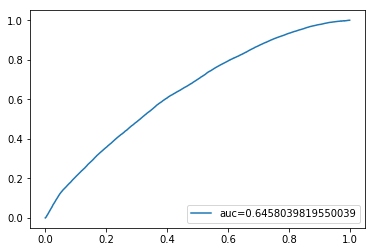

In [220]:
test_prob_LR = logisticRegr.predict_proba(test_ind[features])[::,1]
fpr, tpr, _ = roc_curve(test_dep[response],  test_prob_LR)
auc = roc_auc_score(test_dep[response], test_prob_LR)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

### XGBoost classifier

In [221]:
from xgboost import XGBClassifier

In [222]:
xgb_model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [223]:
xgb_model=xgb_model.fit(train_ind[features], train_dep[response])

/home/srishti/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/srishti/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Prediction XGB

In [224]:
# Predict the on the train_data
test_ind["Pred_state_XGB"] = xgb_model.predict(test_ind[features])

# Predict the on the train_data
train_ind["Pred_state_XGB"] = xgb_model.predict(train_ind[features])

# Predict the on the train_data
kick_projects_ip["Pred_state_XGB"] = xgb_model.predict(kick_projects_ip_scaled_ftrs)

/home/srishti/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srishti/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithC

#### Evaluating XGB classifier

In [225]:
print ("Test Accuracy :: ",accuracy_score(test_dep[response], xgb_model.predict(test_ind[features])))
print ("Train Accuracy :: ",accuracy_score(train_dep[response], xgb_model.predict(train_ind[features])))
print ("Complete Accuracy  :: ",accuracy_score(kick_projects_ip[response], xgb_model.predict(kick_projects_ip_scaled_ftrs)))
print (" Confusion matrix of complete data is", confusion_matrix(kick_projects_ip[response],kick_projects_ip["Pred_state_XGB"]))

/home/srishti/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test Accuracy ::  0.689265650281901


/home/srishti/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train Accuracy ::  0.724243233464845


/home/srishti/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Complete Accuracy  ::  0.7137499057812617
 Confusion matrix of complete data is [[162297  35422]
 [ 59520  74436]]


#### Deriving important features for predicting state of kickstarter projects

In [226]:
## Feature importances
ftr_imp=zip(features,xgb_model.feature_importances_)

In [227]:
for values in ftr_imp:
    print(values)

('goal', 0.06070008)
('usd_goal_real', 0.056941833)
('duration', 0.11121794)
('launched_quarter', 0.06319101)
('launched_month', 0.07590788)
('launched_year', 0.04496788)
('goal_cat_perc', 0.038937204)
('participants', 0.09102827)
('avg_ppb', 0.07027051)
('avg_success_rate', 0.08438579)
('category_3D_Printing', 0.0009614124)
('category_Academic', 0.00074290956)
('category_Accessories', 0.0012673164)
('category_Action', 0.00074290956)
('category_Animals', 0.00043700563)
('category_Animation', 0.0018791242)
('category_Anthologies', 0.00087401125)
('category_Apparel', 0.0017043219)
('category_Apps', 0.001398418)
('category_Architecture', 0.0003496045)
('category_Art', 0.0026657344)
('category_Art_Books', 0.0017480225)
('category_Audio', 0.00039330506)
('category_Bacon', 8.7401124e-05)
('category_Blues', 0.0005244068)
('category_Calendars', 0.0006555085)
('category_Camera_Equipment', 0.00043700563)
('category_Candles', 0.00039330506)
('category_Ceramics', 0.00021850281)
("category_Children

In [228]:
feature_imp=pd.DataFrame(list(zip(features,xgb_model.feature_importances_)))
column_names= ['features','XGB_imp']
feature_imp.columns= column_names

In [229]:
feature_imp= feature_imp.sort_values('XGB_imp',ascending=False)

In [230]:
feature_imp[:15]

,features,XGB_imp
2,duration,0.111218
7,participants,0.091028
9,avg_success_rate,0.084386
4,launched_month,0.075908
8,avg_ppb,0.070271
3,launched_quarter,0.063191
0,goal,0.060700
1,usd_goal_real,0.056942
5,launched_year,0.044968
6,goal_cat_perc,0.038937


In [231]:
kick_projects_ip.head()

,goal,state,usd_goal_real,duration,launched_quarter,launched_month,launched_year,goal_cat_perc,participants,avg_ppb,...,country_MX,country_NL,country_NO,country_NZ,country_NZERO,country_SE,country_SG,country_US,Pred_state_LR,Pred_state_XGB
0,1000.0,0,1533.95,58,3,8,2015,1.0,20,21.108296,...,0,0,0,0,0,0,0,0,0,0
1,30000.0,0,30000.00,59,3,9,2017,3.0,8,213.055474,...,0,0,0,0,0,0,0,1,0,0
2,45000.0,0,45000.00,44,1,1,2013,3.0,74,154.116889,...,0,0,0,0,0,0,0,1,0,0
3,5000.0,0,5000.00,29,1,3,2012,2.0,291,67.673031,...,0,0,0,0,0,0,0,1,0,1
4,50000.0,1,50000.00,34,1,2,2016,2.0,62,88.059601,...,0,0,0,0,0,0,0,1,0,0


### Random Forest Classifier

In [232]:
from sklearn.ensemble import RandomForestClassifier
import math

In [233]:
features_count = train_ind.shape[1]

parameters_rf = {'n_estimators':[50], 'max_depth':[20], 'max_features': 
                     [math.floor(np.sqrt(features_count)), math.floor(features_count/3)]}

def random_forest_classifier(features, target):
    """
    To train the random forest classifier with features and target data
    :param features:
    :param target:
    :return: trained random forest classifier
    """
    clf = RandomForestClassifier(n_estimators=50,criterion='gini' ,max_depth=20, max_features=2)
    clf.fit(features, target)
    return clf

In [234]:
trained_model_RF= random_forest_classifier(train_ind[features], train_dep[response])

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


#### Predictions using RF

In [235]:
# Predict the on the train_data
test_ind["Pred_state_RF"] = trained_model_RF.predict(test_ind[features])

# Predict the on the train_data
train_ind["Pred_state_RF"] = trained_model_RF.predict(train_ind[features])

# Predict the on the train_data
kick_projects_ip["Pred_state_RF"] = trained_model_RF.predict(kick_projects_ip_scaled_ftrs)

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


#### Accuracies of RF

In [236]:
# Train and Test Accuracy
print ("Train Accuracy :: ", accuracy_score(train_dep[response], trained_model_RF.predict(train_ind[features])))
print ("Test Accuracy  :: ", accuracy_score(test_dep[response], trained_model_RF.predict(test_ind[features])))
print ("Complete Accuracy  :: ", accuracy_score(kick_projects_ip[response], trained_model_RF.predict(kick_projects_ip_scaled_ftrs)))
print (" Confusion matrix of complete data is", confusion_matrix(kick_projects_ip[response],kick_projects_ip["Pred_state_RF"]))

Train Accuracy ::  0.6914615026790483
Test Accuracy  ::  0.6576585630584002
Complete Accuracy  ::  0.6813205698349287
 Confusion matrix of complete data is [[180224  17495]
 [ 88203  45753]]


#### Key drivers from Random Forest

In [237]:
## Feature importances
ftr_imp_rf=zip(features,trained_model_RF.feature_importances_)
for values in ftr_imp_rf:
    print(values)

('goal', 0.04376183108297578)
('usd_goal_real', 0.07284438908164442)
('duration', 0.04135476177510749)
('launched_quarter', 0.04550280503725332)
('launched_month', 0.047698485027055405)
('launched_year', 0.06389152169483034)
('goal_cat_perc', 0.04914990282280955)
('participants', 0.04188984630480779)
('avg_ppb', 0.07305561084052069)
('avg_success_rate', 0.07011140989351822)
('category_3D_Printing', 0.00027038504950575236)
('category_Academic', 0.00031408522357940415)
('category_Accessories', 0.0006541962205879866)
('category_Action', 0.00038165937125109314)
('category_Animals', 0.0001589048060893488)
('category_Animation', 0.0003992530053057776)
('category_Anthologies', 0.002096198375159277)
('category_Apparel', 0.002740215090754319)
('category_Apps', 0.011986039753387462)
('category_Architecture', 0.0002803460924720153)
('category_Art', 0.0011656873812309777)
('category_Art_Books', 0.001686461223476293)
('category_Audio', 0.0001303138554606029)
('category_Bacon', 6.359426679583093e-05

In [238]:
feature_imp_RF=pd.DataFrame(list(zip(features,trained_model_RF.feature_importances_)))
column_names_RF= ['features','RF_imp']
feature_imp_RF.columns= column_names_RF

In [240]:
feature_imp_RF= feature_imp_RF.sort_values('RF_imp',ascending=False)
feature_imp_RF[:15]

,features,RF_imp
8,avg_ppb,0.073056
1,usd_goal_real,0.072844
9,avg_success_rate,0.070111
5,launched_year,0.063892
6,goal_cat_perc,0.049150
197,currency_USD,0.048573
4,launched_month,0.047698
3,launched_quarter,0.045503
0,goal,0.043762
7,participants,0.041890
